### Bayesian Entropy Neural Network - Regression problem


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from blitz.modules import BayesianLinear, BayesianLinearSVDLayer
from blitz.utils import variational_estimator
import matplotlib.pyplot as plt
# import seaborn as sns

from siren import Sine

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from torch_truncnorm.TruncatedNormal import TruncatedNormal

from function_collection import *
import matplotlib.pyplot as plt

from functools import partial

# mdmm for constrained optimization
import mdmm

# tensorboard
from torch.utils.tensorboard import SummaryWriter

In [18]:
# create directory for tensorboard logs
import os
if not os.path.exists('benn_varianceConstraint_logs'):
    os.makedirs('benn_varianceConstraint_logs')
    


In [19]:
# Bayesian Entropy Neural Network
# Define NN model
@variational_estimator
class BayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.blinear1 = BayesianLinear(input_dim, 100, bias = True, 
                                       prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')), 
                                                                               torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = -3.0, posterior_rho_init = -1.3)
        self.blinear2 = BayesianLinear(100, 100, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),
                                                                                                              torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = -3.0, posterior_rho_init = -1.3)
        self.blinear3 = BayesianLinear(100, output_dim, bias = True, prior_dist = torch.distributions.Normal(torch.tensor(0.0).to(device = torch.device('cuda:0')),
                                                                                                              torch.tensor(1.0).to(device = torch.device('cuda:0'))), 
                                       posterior_mu_init = -3.0, posterior_rho_init = -1.3)
    def forward(self, x):
        x_ = self.blinear1(x)
        x_ = F.relu(x_)
        x_ = self.blinear2(x_)
        return x_
    

@variational_estimator
class HeteroscedasticBayesianRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Layers for prediction
        posterior_mu_init = 0.0
        posterior_rho_init = -10.0
        
        self.blinear1 = BayesianLinear(input_dim, 100, bias=True, 
                                       prior_dist=torch.distributions.Normal(
                                           torch.tensor(0.0).to(device=torch.device('cuda:0')),
                                           torch.tensor(1.0).to(device=torch.device('cuda:0'))),
                                       posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        self.blinear2 = BayesianLinear(100, 100, bias=True,
                                       prior_dist=torch.distributions.Normal(
                                           torch.tensor(0.0).to(device=torch.device('cuda:0')),
                                           torch.tensor(1.0).to(device=torch.device('cuda:0'))),
                                       posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        self.blinear3 = BayesianLinear(100, output_dim, bias=True,
                                prior_dist=torch.distributions.Normal(
                                    torch.tensor(0.0).to(device=torch.device('cuda:0')),
                                    torch.tensor(1.0).to(device=torch.device('cuda:0'))),
                                posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)

    

    def forward(self, x):
        # Prediction path
        x = F.relu(self.blinear1(x))
        
        x = F.relu(self.blinear2(x))
        x = self.blinear3(x)    
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)
        

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise
    
@variational_estimator
class UniformPriorHeteroscedasticRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Layers for prediction
        posterior_mu_init = 0.0
        posterior_rho_init = -7.5
        uniform_low = -25
        uniform_high = 25
        
        self.blinear = nn.Sequential(
            BayesianLinear(input_dim, 100, bias=True, 
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
            nn.Tanh(),
            BayesianLinear(100, output_dim, bias=True,
                           prior_dist=torch.distributions.Uniform(
                               torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
                               torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
                           posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        )

        # self.blinear_mean = nn.Sequential(
        #     BayesianLinear(input_dim, 100, bias=True, 
        #                    prior_dist=torch.distributions.Uniform(
        #                        torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
        #                        torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
        #                    posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
        #     nn.ReLU(),
        #     BayesianLinear(100, 1, bias=True,
        #                    prior_dist=torch.distributions.Uniform(
        #                        torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
        #                        torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
        #                    posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        # )
        
        # self.blinear_log_noise = nn.Sequential(
        #     BayesianLinear(input_dim, 100, bias=True, 
        #                    prior_dist=torch.distributions.Uniform(
        #                        torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
        #                        torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
        #                    posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init),
        #     nn.ReLU(),
        #     BayesianLinear(100, 1, bias=True,
        #                    prior_dist=torch.distributions.Uniform(
        #                        torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
        #                        torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
        #                    posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
        # )
        
    def forward(self, x):
        # Prediction path
        
        x = self.blinear(x)
        
        # x_pred = self.blinear_mean(x)
        # x_log_noise = self.blinear_log_noise(x)
        x_pred = x[:, 0].unsqueeze(1)
        x_log_noise = x[:, 1].unsqueeze(1)

        # resolve x_log_noise to be positive
        x_log_noise = torch.log1p(torch.exp(x_log_noise))
        return x_pred, x_log_noise




# @variational_estimator
# class SVD_Parameterized_UniformPriorHeteroscedasticRegressor(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         # Layers for prediction
#         posterior_mu_init = 0.0
#         posterior_rho_init = -1.5
#         uniform_low = -1.0
#         uniform_high = 1.0
        
#         self.blinear1 = BayesianLinearSVDLayer(input_dim, 100, bias=True, 
#                                        prior_dist=torch.distributions.Uniform(
#                                            torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
#                                            torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
#                                        posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
#         self.blinear2 = BayesianLinearSVDLayer(100, 100, bias=True,
#                                        prior_dist=torch.distributions.Uniform(
#                                            torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
#                                            torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
#                                        posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)
#         self.blinear3 = BayesianLinearSVDLayer(100, output_dim, bias=True,
#                                 prior_dist=torch.distributions.Uniform(
#                                     torch.tensor(uniform_low).to(device=torch.device('cuda:0')),
#                                     torch.tensor(uniform_high).to(device=torch.device('cuda:0'))),
#                                 posterior_mu_init=posterior_mu_init, posterior_rho_init=posterior_rho_init)

#     def get_V(self, x):
#         xTx = torch.mm(x.t(), x)
#         _, V = torch.symeig(xTx, eigenvectors=True)
#         return V
    
#     def forward(self, x):
#         # Prediction path
#         x = F.relu(self.blinear1(x))
#         V = self.get_V(x)
#         x = F.relu(self.blinear2(x, V))
#         x = self.blinear3(x)
#         x_pred = x[:, 0].unsqueeze(1)
#         x_log_noise = x[:, 1].unsqueeze(1)
        
#         # resolve x_log_noise to be positive
#         x_log_noise = torch.log1p(torch.exp(x_log_noise))
#         return x_pred, x_log_noise
    


In [20]:
def value_constraints(data):
    X_test = np.array([vc[0] for vc in data]).reshape(-1, 1)
    y_test = np.array([vc[1] for vc in data]).reshape(-1, 1)
    return np.concatenate((X_test, y_test), axis=0)

X_test, y_test = value_constraints([[40, 33]])
# 

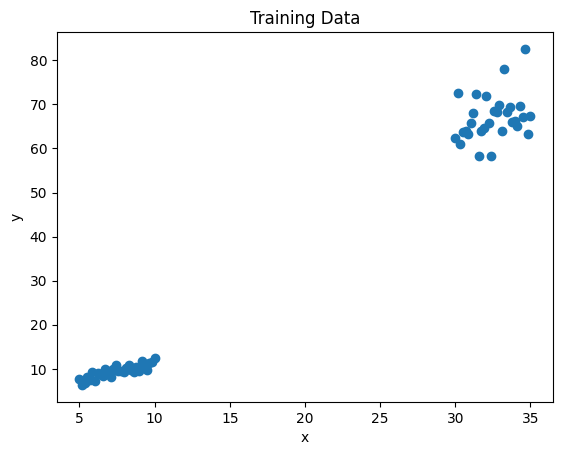

In [21]:
import numpy as np
# Training data
'''
The training data is a polynomial function with noise added to it. 
There are two regions of training data, the first from x = 5 to x = 10
and the second from x = 30 to x = 35. The first one has sigma = 1 
and the second one has sigma = 3.
'''
# Training data
x1 = np.linspace(5, 10, 30)
y1 = np.polyval([1,2], x1) + np.random.normal(0, 1, len(x1))

x2 = np.linspace(30, 35, 30)
y2 = np.polyval([2,3], x2) + np.random.normal(0, 5, len(x2))

X_train = np.concatenate((x1, x2))
y_train = np.concatenate((y1, y2))

# Plot the training data

plt.scatter(X_train, y_train)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Training Data')
plt.show()
# Create dataloader for regression task
X_train, y_train = torch.tensor(X_train).float(), torch.tensor(y_train).float()
# X_test, y_test = torch.tensor(X_test).float(), torch.tensor(y_test).float()

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=1000, shuffle=True)


# ds_test = torch.utils.data.TensorDataset(X_test, y_test)
# dataloader_test = torch.utils.data.DataLoader(ds_test, batch_size=1000, shuffle=True)



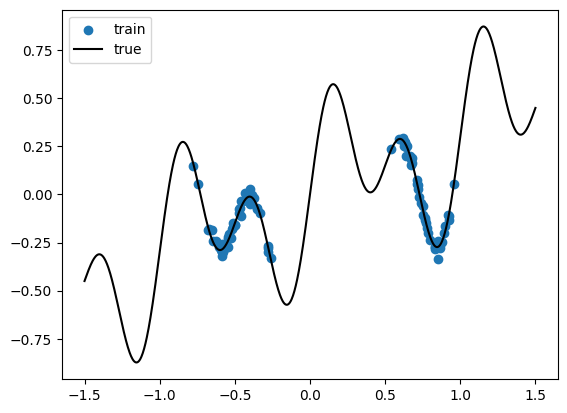

In [22]:
def reg1d(state=None):
    
    np.random.seed(123)
    def f(x):
        return 0.3 * x + 0.3 * np.sin(2*np.pi*x) + 0.3 * np.sin(4*np.pi*x)

    Xt = np.linspace(-1.5, 1.5, 1000)
    yt = f(Xt)

    Xs = np.random.randn(50)*0.1 - 0.5
    Xs = np.concatenate((Xs, np.random.randn(50)*0.1 + 0.75))
    ys = f(Xs) + 0.02 * np.random.randn(Xs.shape[0])
    
    Xval = np.random.randn(10)*0.1 - 0.5
    Xval = np.concatenate((Xval, np.random.randn(10)*0.1 + 0.75))
    yval = f(Xval) + 0.02 * np.random.randn(Xval.shape[0])

    return (Xs.reshape(-1, 1), ys.astype(np.float32),
            Xval.reshape(-1, 1), yval.astype(np.float32),
            Xval.reshape(-1, 1), yval.astype(np.float32),
            Xt.reshape(-1, 1), yt.astype(np.float32))


def reg1d_v2():
    np.random.seed(123)
    def f(x):
        return 0.3 * x + 0.3 * np.sin(2*np.pi*x) + 0.3 * np.sin(4*np.pi*x)

    Xt = np.linspace(-1.5, 1.5, 1000)
    yt = f(Xt)

    Xs = np.random.randn(50)*0.1 - 0.5
    Xs = np.concatenate((Xs, np.random.randn(50)*0.1 + 0.75))
    ys = f(Xs) + 0.02 * np.random.randn(Xs.shape[0])
    
    Xval = np.random.randn(10)*0.1 - 0.5
    Xval = np.concatenate((Xval, np.random.randn(10)*0.1 + 0.75))
    yval = f(Xval) + 0.02 * np.random.randn(Xval.shape[0])

    return (Xs.reshape(-1, 1), ys.astype(np.float32),
            Xval.reshape(-1, 1), yval.astype(np.float32),
            Xval.reshape(-1, 1), yval.astype(np.float32),
            Xt.reshape(-1, 1), yt.astype(np.float32))



X_train, y_train, X_val, y_val, X_test, y_test, Xt, yt = reg1d()
# plot the data
plt.scatter(X_train, y_train, label='train')
plt.plot(Xt, yt, color = 'black', label='true')
plt.legend()
plt.show()

# create dataloader
X_train, y_train, X_val, y_val, X_test, y_test, Xt, yt = map(lambda x: torch.tensor(x).float(), reg1d())
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=100, shuffle=True)




In [ ]:
# # create moment constraint ground truth 

# def build_moment_constraint(data, alpha):
#     '''
#     data: torch dataset
#     '''
#     # first moment needs to increase at the rate of \alpha * (x - x_0), where x_0 is the 
#     # nearest neighbor of x, x_0 belongs to data. Constraint only applies in the neighborhood
#     # of x_0, i.e. x_0 - \epsilon < x < x_0 + \epsilon
#     # convert data to numpy array
#     data = np.array(data)
#     x = np.array([4.0, 12.0, 28.0, 38.0])
#     epsilon = 5
    
#     # for each x, find the nearest neighbor in data and check if it is within the neighborhood
#     # if yes, then add the constraint
#     moment_constraint__ = []
#     for x_ in x:
#         # find the nearest neighbor
#         nearest_neighbor = data[np.argmin(np.abs(data[:, 0] - x_))]
#         if nearest_neighbor[0] - epsilon < x_ < nearest_neighbor[0] + epsilon:
#             # add the constraint
#             # moment_constraint__.append([x_, nearest_neighbor[1] + alpha * np.abs((x_ - nearest_neighbor[0]))])
#             moment_constraint__.append([x_, alpha*np.abs((x_ - nearest_neighbor[0]))])
#             # print('neighborhood:', nearest_neighbor[0] - epsilon, nearest_neighbor[0] + epsilon, 'x:', x_)
#             # print('nearest neighbor:', nearest_neighbor, 'moment:', alpha* np.abs((x_ - nearest_neighbor[0])))
#     moment_constraint__ = torch.tensor(moment_constraint__).float()
#     return moment_constraint__ 
# moment_constraints_1 = build_moment_constraint(ds_train, alpha = 1)
# moment_constraints_2 = build_moment_constraint(ds_train, alpha = 2)
# moment_constraints_3 = build_moment_constraint(ds_train, alpha = 9)
# print(moment_constraints_1[:,1], moment_constraints_2[:,1], moment_constraints_3[:,1])
# print(moment_constraints_1[:,0], moment_constraints_2[:,0], moment_constraints_3[:,0])


In [ ]:
# torch.random.seed()
# no_points = 300
# lengthscale = 1
# variance = 1.0
# sig_noise = 0.1
# def fun(x):
#     return (np.arctan(20*x - 10) - np.arctan(-10))/3        
# def constant_function(val):
#     """ Return the constant function"""
#     def fun(x):
#         return torch.zeros(x.shape[0])+val
    
#     return fun

# def fun_UB(x):
#     """ Upper bound function """
#     return torch.log(25*x.flatten() + 1)/3+0.05      



# x_test = np.linspace(0.08, 1, 100)
# y_true = fun(x_test)

# n = 100
# noise_std = 0.1
# np.random.seed(1)
# x_design = np.random.uniform(0.1, 0.65, n)
# x_design.sort(axis = 0)
# np.random.seed(10)
# y_design = fun(x_design) + np.random.normal(0, noise_std, n)

# positive_index=np.where(y_design>=0)[0]
# x_design=x_design[positive_index]
# y_design=y_design[positive_index]
# # diff_y=np.diff(y_design)
# # print(diff_y)
# # mono_index=(np.where(diff_y<1e-8))[0]+1
# train=np.stack((x_design,y_design),axis=-1)
# np.random.shuffle(train)

# x_mean, x_std = x_design.mean(), x_design.var()**0.5
# y_mean, y_std = y_design.mean(), y_design.var()**0.5
# # x_train=  torch.FloatTensor(x_design[:,np.newaxis])      
# # y_train=  torch.FloatTensor(y_design[:,np.newaxis])      
# # x_test=  torch.FloatTensor(x_test)      
# # y_true=  torch.FloatTensor(y_true)   
# print(x_mean, x_std,y_mean, y_std)


# sigma=0.1

# ntrain=n

# # plot the training data, the true function, and the upper and lower bounds
# plt.figure(figsize=(10, 5))
# plt.plot(x_test, y_true, 'k', label='True function')
# plt.scatter(train[:,0], train[:,1], label='Training data')
# plt.plot(x_test, fun_UB(torch.FloatTensor(x_test)), 'r', label='Upper bound')
# plt.plot(x_test, constant_function(0)(torch.FloatTensor(x_test)), 'b', label='Lower bound')
# plt.legend()
# plt.xlabel('x')
# plt.ylabel('y')

# # transfer the data to torch tensors 
# x_train=  torch.FloatTensor(train[:,0][:,np.newaxis])
# y_train=  torch.FloatTensor(train[:,1][:,np.newaxis])
# x_test=  torch.FloatTensor(x_test[:,np.newaxis])
# y_true=  torch.FloatTensor(y_true[:,np.newaxis])
# y_test=  torch.FloatTensor(y_test[:,np.newaxis])

# dataloader_train = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=100, shuffle=True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# # regressor = BayesianRegressor(1, 1).to(device)

# def log_gaussian_loss(output, target, sigma, no_dim):
#     exponent = -0.5*(target - output)**2/sigma**2   #exponent is negative term
    
#     log_coeff = -no_dim*torch.log(sigma)  #sigma here means exp(sigma), so log_coeff=sigma.
    
#     return - ( exponent+log_coeff).sum()


# regressor_benn = HeteroscedasticBayesianRegressor(1, 1).to(device)
# # criterion_benn is the log_gaussian_loss 
# # criterion_benn = partial(log_gaussian_loss, sigma=torch.exp(regressor_benn.log_noise), no_dim=1)

# # criterion_benn GaussianNLL Loss Heteroscedastic
# criterion_benn = nn.GaussianNLLLoss()
# # criterion_benn = partial(nn.GaussianNLLLoss, var = regressor_benn.log_noise, full = True, reduction = 'mean')

In [ ]:
# # mdmm constraint implementation
# def equality_constraint_fn_1(*args, **kwargs):
#     predictions = regressor_benn(X_test.reshape(-1,1).to(device))
#     return predictions.reshape(-1).squeeze()

# def moment_constraint_fn(*args, **kwargs):
#     eps = 0.1
#     preds_1 = [regressor_benn((moment_constraints_1[:,0] + eps).unsqueeze(1))[0] for i in range(5)]
#     preds_2 = [regressor_benn((moment_constraints_1[:,0] - eps).unsqueeze(1))[0] for i in range(5)]
#     # predictions = [regressor_benn(moment_constraints_1[:,0].unsqueeze(1))[0] for i in range(20)]
#     std_pred_1 = torch.std(torch.stack(preds_1), dim = 0)
#     std_pred_2 = torch.std(torch.stack(preds_2), dim = 0)
#     # slope of std_pred
#     d_std_pred = (std_pred_1 - std_pred_2)/(2*eps)
#     return d_std_pred
# moment_constraints_1 = moment_constraints_1.to(device)
# # value_constraint = mdmm.EqConstraint(equality_constraint_fn_1, y_test.squeeze().to(device))
# moment_constraint = mdmm.MinConstraint(moment_constraint_fn, moment_constraints_1[:,1].unsqueeze(1))
# mdmm_module = mdmm.MDMM([moment_constraint])



In [ ]:
# import time
# iteration = 0
# best_loss = 1e6
# opt_benn = mdmm_module.make_optimizer(regressor_benn.parameters(), lr = 1e-3)

# N = 3
# regressor_benn.train()

# eta_history = []
# loss_history = []
# loss_data_history = []
# loss_constraint_history = []

# best_loss = 1e9
# # create summary writer based on datetime
# import datetime
# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# writer = SummaryWriter('benn_varianceConstraint_logs/' + current_time)
# time_elapsed_ = []
# for epoch in range(2000):
#     for i, (datapoints, labels) in enumerate(dataloader_train):
#         datapoints = datapoints.reshape(-1, 1).to(device)
#         labels = labels.reshape(-1, 1).to(device)
#         start_time = time.time()
#         loss_data = regressor_benn.sample_elbo_heteroscedastic(inputs=datapoints.to(device),
#                            labels=labels.to(device),
#                            criterion=criterion_benn,
#                            sample_nbr=3,
#                            complexity_cost_weight=1/X_train.shape[0])        
#         mdmm_return = mdmm_module(loss_data)
#         opt_benn.zero_grad()
#         mdmm_return.value.backward()
#         opt_benn.step()
#         # check if the loss is lower than the best_loss
#         if mdmm_return.value.item() < best_loss:
#             best_loss = loss_data
#             best_model_benn = regressor_benn
        
#         loss_data_history.append(loss_data.item())
#         iteration += 1
#         end_time = time.time()
#         time_elapsed_.append(end_time - start_time)
#         if iteration%10==0:
#             print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_data.item(), 'Constraint_Infeasibility:', mdmm_return.infs[0].mean().item())


In [ ]:
import time
iteration = 0
best_loss = 1e6

regressor = UniformPriorHeteroscedasticRegressor(1,2).to(device)
criterion = nn.GaussianNLLLoss()
N = 3
regressor.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('benn_varianceConstraint_logs/' + current_time)
time_elapsed_ = []
opt = optim.Adam(regressor.parameters(), lr=1e-3)


In [ ]:
best_loss = 1e9

In [ ]:
for epoch in range(2000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        _, loss_total, loss_data, loss_compleixty = regressor.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        if torch.isnan(loss_total).item():
            print('Loss is NaN at iteration:', iteration)
            break

        if loss_data.item() < best_loss:
            # check if loss is nan
            best_loss = loss_data.item()
            # best_model params are saved 
            best_model = regressor
            

        opt.zero_grad()
        loss_total.backward()
        opt.step()
        iteration += 1
        if iteration%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Iteration:', iteration, 'Total Loss:', loss_total.item(), 'Likelihood Loss:', loss_data.item(), 'Complexity Loss:', loss_compleixty.item())


In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-5, 5, 200).reshape(-1,1)

# preds_benn = [best_model_benn(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
# preds_benn = np.stack(preds_benn)
# mean_benn = preds_benn.mean(axis=0)
# ale_benn = best_model_benn(x_plot.to(device))[1].cpu().detach().numpy()
# std_benn = preds_benn.std(axis=0)
# ci_upper_benn = mean_benn + (3*std_benn)
# ci_lower_benn = mean_benn - (3*std_benn)
preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds = np.stack(preds)
mean = preds.mean(axis=0)
ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
ale_std = ale**0.5

std = preds.std(axis=0)
std = std**0.5
# compute the slope of the std 
slope_std = np.diff(std.squeeze())/np.diff(x_plot.squeeze())
# print it from x >= 2

ci_upper_ale = mean + (2*ale_std)
ci_lower_ale = mean - (2*ale_std)

ci_lower = mean - (2*std)
ci_upper = mean + (2*std)


# plt.plot(x_plot, mean_benn, color='black', label='Learned Function with BENN Constraint')
# plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='black', alpha=0.5)
plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.plot(Xt, yt, color = 'blue', label='True Function')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5, label = 'Epistemic Uncertainty')
plt.fill_between(x_plot.squeeze(), ci_lower_ale.squeeze(), ci_upper_ale.squeeze(), color='green', alpha=0.5, label = 'Aleatoric Uncertainty')
plt.xlabel('X')
plt.ylabel('y')
# plt.xlim(-10, 10)
plt.legend()
plt.show()
# compute the derivative of std with respect to x_plot
slope_std = np.gradient(std.squeeze(), x_plot.squeeze())

# plot std vs x_plot
plt.plot(x_plot, std, color='red', label='Standard Deviation')
# fill_between the training data range - a vertical line
# plt.axvline(x = X_train.min(), color = 'black', linestyle = '--', label = 'Training Data Range')
# plt.axvline(x = X_train.max(), color = 'black', linestyle = '--')
# plot training data as 'x's
plt.scatter(X_train,np.zeros_like(X_train), color='blue', label='Training Data', s=10)
plt.xlabel('X')
plt.ylabel('Std. Dev. Epistemic Uncertainty')
plt.legend()
plt.show()


In [ ]:

model_ = UniformPriorHeteroscedasticRegressor(1, 2).to(device)


In [ ]:
def distance_aware_variance_constraint(*args, **kwargs):
    '''
    Variance is already returned by nn prediction. 
    '''
    preds = [model_(x_second_step.to(device))[0] for _ in range(10)]
    std = torch.stack(preds).std(dim=0)
    return std**0.5
    # return model_(x_second_step.to(device))[1]**0.5
    
# Create a ground truth functional relationship for the variance
def distance_aware_variance_ground_truth(nn_):
    '''
    y_test is higher when we're further away from the training data domain. The variance
    should be lower-bounded by this function.
    Params:
    nn_ : torch tensor of shape (n, 1) - The nearest neighbor of x_ in the training data
    '''
    # f\left(x\right)=\left(k^{2}\exp\left(-\frac{\left(x\right)}{2l^{2}}\right)\right)^{-1}
    k = 2.8
    l = 0.4
    y_test = (k**2 * torch.exp(-nn_/(2*l**2)))**-1
    # clip values above 1 to 1
    return torch.clamp(y_test, min=0, max=1)


In [ ]:

# domain of x now is -5 to 5
x_second_step = torch.linspace(-5, 5, 100).reshape(-1,1)

# for each element in x_second_step, find the distance to nearest neighbor in X_train
nn_distances = []
for x_ in x_second_step:
    nn_distances.append(torch.min(torch.abs(X_train - x_)))
nn_distances = torch.stack(nn_distances).reshape(-1,1)

y_test = distance_aware_variance_ground_truth(nn_distances)

# plot the ground truth variance
plt.plot(x_second_step, y_test)
plt.xlabel('x')
plt.ylabel('Variance')
plt.title('Ground Truth Variance')
plt.show()

variance_constraint_fn = mdmm.MinConstraint(distance_aware_variance_constraint, y_test.to(device))
mdmm_module = mdmm.MDMM([variance_constraint_fn])
opt_ = mdmm_module.make_optimizer(model_.parameters(), lr = 1e-3)
criterion = nn.GaussianNLLLoss()

In [ ]:
# create a dataset ds_second_step that has x_second_step, nn_distances, X_train, y_train
ds_second_step = torch.utils.data.TensorDataset(x_second_step, nn_distances, X_train, y_train)
dataloader_second_step = torch.utils.data.DataLoader(ds_second_step, batch_size=100, shuffle=True)

In [ ]:
model_.train()
iteration = 0
for epoch in range(2000):
    for i, (datapoints, nn__, datapoints_train, labels) in enumerate(dataloader_second_step):
        datapoints = datapoints.to(device)
        nn__ = nn__.to(device)
        datapoints_train = datapoints_train.to(device)
        labels = labels.to(device)
        _, loss_total, likelihood_loss, complexity_loss = model_.sample_elbo_detailed_heteroscedastic_loss(inputs=datapoints_train.to(device),
                           labels = labels.to(device),
                           criterion=criterion,
                           sample_nbr=1,
                           complexity_cost_weight=1/X_train.shape[0])
        # if torch.isnan(loss_total).item():
        #     print('Loss is NaN at iteration:', iteration)
        #     break

        # if loss_total.item() < best_loss:
        #     # check if loss is nan
        #     best_loss = loss_total.item()
        #     # best_model params are saved 
        #     best_model_second_step = model_
        mdmm_return = mdmm_module(loss_total)
        variance_loss = mdmm_return.infs[0].mean()

        opt_.zero_grad()
        loss_total.backward()
        opt_.step()
        iteration += 1
        if iteration%10==0:
            # print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_total.item())
            print('Epoch:', epoch, 'Iteration:', iteration, 'Total Loss:', loss_total.item(), 'Variance Loss:', variance_loss.item(), 'Complexity Loss:', complexity_loss.item(), 'Likelihood Loss:', likelihood_loss.item())
    


In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-5, 5, 100).reshape(-1,1)

preds_benn = [model_(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)

ale_benn = model_(x_plot.to(device))[1].cpu().detach().numpy()
ale_benn = ale_benn**0.5

std_benn = preds_benn.std(axis=0)
mean_benn = preds_benn.mean(axis=0)

std_benn = std_benn**0.5
ci_upper_benn = mean_benn + (2*std_benn)
ci_lower_benn = mean_benn - (2*std_benn)


preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]

preds = np.stack(preds)
mean = preds.mean(axis=0)

ale = model_(x_plot.to(device))[1].cpu().detach().numpy()
ale_std = ale**0.5

std = preds.std(axis=0)
std = std**0.5
ci_upper = mean + (2*std)
ci_lower = mean - (2*std)

plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.plot(x_plot, mean_benn, color='black', label='Learned Function with Variance Constraint')
plt.plot(Xt, yt, color = 'blue', label='True Function')
plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5, label = 'Epistemic Uncertainty - No Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='green', alpha=0.5, label = 'Epistemic Uncertainty - Variance Constraint')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

# plot the variance
fig = plt.figure(figsize=(10, 6))
plt.plot(x_plot, std, color='red', label='Variance - No Constraint')
plt.plot(x_plot, std_benn, color='green', label='Variance - Variance Constraint')
plt.plot(x_plot, y_test, color='black', label='Ground Truth Variance Bound')
# training data
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
# plt legend on the right corner
plt.legend(loc='upper right')
plt.xlabel('X')
plt.ylabel('Epistemic Uncertainty')


In [ ]:

# plot a uniform prior distribution [-5, 5] and a normal distribution with mu = 0 and sigma = log1p(exp(-0.1))
x = torch.linspace(-10, 10, 100)
uniform_prior = torch.distributions.Uniform(-5, 5)
normal_variational_posterior = torch.distributions.Normal(0, torch.log1p(torch.exp(-0.1)))
# plot the pdfs
plt.plot(x, uniform_prior.log_prob(x), label='Uniform Prior')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# regressor = BayesianRegressor(1, 1).to(device)

def log_gaussian_loss(output, target, sigma, no_dim):
    exponent = -0.5*(target - output)**2/sigma**2   #exponent is negative term
    
    log_coeff = -no_dim*torch.log(sigma)  #sigma here means exp(sigma), so log_coeff=sigma.
    
    return - ( exponent+log_coeff).sum()


regressor_benn_bigAlpha = HeteroscedasticBayesianRegressor(1, 1).to(device)
# criterion_benn is the log_gaussian_loss 
# criterion_benn = partial(log_gaussian_loss, sigma=torch.exp(regressor_benn.log_noise), no_dim=1)

# criterion_benn GaussianNLL Loss Heteroscedastic
criterion_benn = nn.GaussianNLLLoss()
# criterion_benn = partial(nn.GaussianNLLLoss, var = regressor_benn.log_noise, full = True, reduction = 'mean')

def moment_constraint_fn_3(*args, **kwargs):
    eps = 0.1
    preds_1 = [regressor_benn((moment_constraints_3[:,0] + eps).unsqueeze(1))[0] for i in range(5)]
    preds_2 = [regressor_benn((moment_constraints_3[:,0] - eps).unsqueeze(1))[0] for i in range(5)]
    # predictions = [regressor_benn(moment_constraints_1[:,0].unsqueeze(1))[0] for i in range(20)]
    std_pred_1 = torch.std(torch.stack(preds_1), dim = 0)
    std_pred_2 = torch.std(torch.stack(preds_2), dim = 0)
    # slope of std_pred
    d_std_pred = (std_pred_1 - std_pred_2)/(2*eps)
    return d_std_pred

moment_constraints_3 = moment_constraints_3.to(device)
# value_constraint = mdmm.EqConstraint(equality_constraint_fn_1, y_test.squeeze().to(device))
moment_constraint_n3 = mdmm.MinConstraint(moment_constraint_fn_3, moment_constraints_3[:,1].unsqueeze(1))
mdmm_module = mdmm.MDMM([moment_constraint_n3])

import time
iteration = 0
best_loss = 1e6
opt_benn = mdmm_module.make_optimizer(regressor_benn.parameters(), lr = 1e-3)

N = 3
regressor_benn_bigAlpha.train()

eta_history = []
loss_history = []
loss_data_history = []
loss_constraint_history = []

best_loss = 1e9
# create summary writer based on datetime
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

writer = SummaryWriter('benn_varianceConstraint_logs/' + current_time)
time_elapsed_ = []
for epoch in range(5000):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        datapoints = datapoints.reshape(-1, 1).to(device)
        labels = labels.reshape(-1, 1).to(device)
        start_time = time.time()
        loss_data = regressor_benn_bigAlpha.sample_elbo_heteroscedastic(inputs=datapoints.to(device),
                           labels=labels.to(device),
                           criterion=criterion_benn,
                           sample_nbr=3,
                           complexity_cost_weight=1/X_train.shape[0])        
        mdmm_return = mdmm_module(loss_data)
        opt_benn.zero_grad()
        mdmm_return.value.backward()
        opt_benn.step()
        # check if the loss is lower than the best_loss
        if mdmm_return.value.item() < best_loss:
            best_loss = loss_data
            best_model_benn_bigAlpha = regressor_benn_bigAlpha
        
        loss_data_history.append(loss_data.item())
        iteration += 1
        end_time = time.time()
        time_elapsed_.append(end_time - start_time)
        if iteration%10==0:
            print('Epoch:', epoch, 'Iteration:', iteration, 'Loss:', loss_data.item(), 'Constraint_Infeasibility:', mdmm_return.infs[0].mean().item())


In [ ]:
# Plot the training data, and the learned function using test data linearly spaced torch tensor
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', label='Training Data', s=10)
x_plot = torch.linspace(-100, 100, 500).reshape(-1,1)

preds_benn = [best_model_benn_bigAlpha(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
preds_benn = np.stack(preds_benn)
mean_benn = preds_benn.mean(axis=0)
ale_benn = best_model_benn(x_plot.to(device))[1].cpu().detach().numpy()
std_benn = preds_benn.std(axis=0)
ci_upper_benn = mean_benn + (3*std_benn)
ci_lower_benn = mean_benn - (3*std_benn)

# preds = [best_model(x_plot.to(device))[0].cpu().detach().numpy() for _ in range(100)]
# preds = np.stack(preds)
# mean = preds.mean(axis=0)
# ale = best_model(x_plot.to(device))[1].cpu().detach().numpy()
# std = preds.std(axis=0)
# ci_upper = mean + (3*std)
# ci_lower = mean - (3*std)


plt.plot(x_plot, mean_benn, color='black', label='Learned Function with BENN Constraint')
# plt.plot(x_plot, mean, color='red', label='Learned Function without Constraint')
plt.fill_between(x_plot.squeeze(), ci_lower_benn.squeeze(), ci_upper_benn.squeeze(), color='black', alpha=0.5)
# plt.fill_between(x_plot.squeeze(), ci_lower.squeeze(), ci_upper.squeeze(), color='red', alpha=0.5)
# plot ale_benn
# plt.fill_between(x_plot.squeeze(), ale_lower_benn.squeeze(), ale_upper_benn.squeeze(), color='red', alpha=0.25)
plt.xlabel('X')
plt.ylabel('y')
# plt.xlim(-10, 10)
plt.legend()
plt.show()
